# European Central Bank Exchange Rates Analysis

The purpose of this notebook is to explore the integrity of the daily exchange
rate data files published by the ECB. Specifically, we want to understand if the
data is sufficient to fulfill the goal of intelligently timing the exchange of
currency between countries as an individual with a presence both in and outside
the EU. 

Specifically, we want to know:

* What is the current exchange rate?
* What is the recent trend in the exchange rate?
* How does the current exchange rate compare to the historical exchange rate a week, month, and year ago?


In [1]:
import holidays
import pandas as pd
import seaborn as sns

In [46]:
df = pd.read_csv('./eurofxref-hist.csv')
# convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')\
    .sort_index(ascending=True)

In [47]:
df.head()

,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,LTL,...,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR,Unnamed: 42
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,1.1789,133.73,NaN,0.58231,35.107,7.4501,15.6466,0.71110,251.48,4.7170,...,NaN,1398.59,NaN,NaN,2.2229,NaN,1.9554,NaN,6.9358,NaN
1999-01-05,1.1790,130.96,NaN,0.58230,34.917,7.4495,15.6466,0.71220,250.80,4.7174,...,NaN,1373.01,NaN,NaN,2.2011,NaN,1.9655,NaN,6.7975,NaN
1999-01-06,1.1743,131.42,NaN,0.58200,34.850,7.4452,15.6466,0.70760,250.67,4.6994,...,NaN,1359.54,NaN,NaN,2.1890,NaN,1.9699,NaN,6.7307,NaN
1999-01-07,1.1632,129.43,NaN,0.58187,34.886,7.4431,15.6466,0.70585,250.09,4.6548,...,NaN,1337.16,NaN,NaN,2.1531,NaN,1.9436,NaN,6.8283,NaN
1999-01-08,1.1659,130.09,NaN,0.58187,34.938,7.4433,15.6466,0.70940,250.15,4.6643,...,NaN,1366.73,NaN,NaN,2.1557,NaN,1.9537,NaN,6.7855,NaN


In [48]:
# get the earliest and latest date 
earliest_date = df.index.min()
latest_date = df.index.max()

print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")

Earliest date: 1999-01-04 00:00:00
Latest date: 2025-07-31 00:00:00


# Q: How complete and clean is the data?

It's important to know the level of cleaning and preprocessing that will be
required to make the data analysis-ready. If it's extensive, we'd consider
introducing an ETL/ELT tool like dbt into the tech stack.

Completeness is also important to know whether the data is good enough for the use
case.

### Check data types

If there are mixed number formats in a single column in the input
data, pandas will load it as an object.

In our case, we see no issues as all columns except Date are floats (numeric).

In [49]:
df.dtypes.value_counts()

float64    42
Name: count, dtype: int64

### Check currency names

Look for malformed currrency codes.

In this case, it looks like the last column is problematic.

In [71]:
df.columns

Index(['USD', 'JPY', 'BGN', 'CYP', 'CZK', 'DKK', 'EEK', 'GBP', 'HUF', 'LTL',
       'LVL', 'MTL', 'PLN', 'ROL', 'RON', 'SEK', 'SIT', 'SKK', 'CHF', 'ISK',
       'NOK', 'HRK', 'RUB', 'TRL', 'TRY', 'AUD', 'BRL', 'CAD', 'CNY', 'HKD',
       'IDR', 'ILS', 'INR', 'KRW', 'MXN', 'MYR', 'NZD', 'PHP', 'SGD', 'THB',
       'ZAR', 'Unnamed: 42'],
      dtype='object')

In [73]:
df['Unnamed: 42'].isnull().sum()

np.int64(6806)

In [74]:
df.shape

(6806, 42)

It appears that there's a useless all-null column loaded at the end of the dataframe.

To handle this we remove all columns that are 100% null. This step will need to
be implemented in the automated data flow.

In [75]:
null_columns = df.columns[df.isnull().all()]
df = df.drop(columns=null_columns)

In [76]:
df.shape

(6806, 41)

### Check null values

Look for missing values.

In [77]:
df.isnull().sum()

USD       0
JPY       0
BGN     398
CYP    4502
CZK       0
DKK       0
EEK    3732
GBP       0
HUF       0
LTL    2709
LVL    2964
MTL    4502
PLN       0
ROL    5142
RON    1664
SEK       0
SIT    4757
SKK    4246
CHF       0
ISK    2341
NOK       0
HRK    2258
RUB    2473
TRL    5269
TRY    1537
AUD       0
BRL    2304
CAD       0
CNY    1599
HKD       0
IDR    1599
ILS    3074
INR    2560
KRW       0
MXN    2304
MYR    1599
NZD       0
PHP    1599
SGD       0
THB    1599
ZAR       0
dtype: int64

Quite a few currencies have missing values. However, this could be due to a
currency starting or stopping as countries join the Eurozone, or inclusion/removal
from ECB's tracking.

Let's look at Croatia (HRK) as an example, since they didn't change to the Euro
until 2023.

Text(0.5, 1.0, 'EUR to HRK (Croatia)')

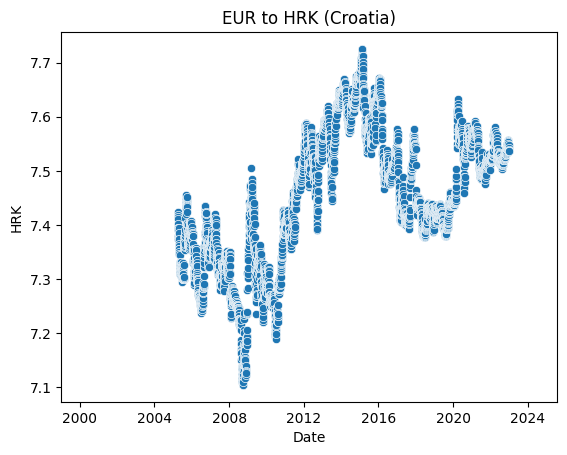

In [78]:
ax = sns.scatterplot(data=df, x='Date', y='HRK')
# adjust x-axis to be from min to max date
ax.set_xlim(earliest_date, latest_date)
ax.set_title('EUR to HRK (Croatia)')

ECB started tracking HRK when Croatia became a candidate to join the EU in 2004,
and stopped once Croatia adopted the Euro in 2023. Therefore, the null values
are on both sides of this tracking period.

These null values are **not** problematic. However, we want to confirm there
aren't null values during an official period of exchange rate tracking. We'll
take a look at the gaps between non-null values.

In [85]:
currency_gap_distribution = pd.DataFrame(columns=['currency', 'gap', 'count'])

for currency in df.columns.unique():
    nonnull_series = df[df[currency].notna()][currency]

    extract_days = lambda x: x.total_seconds() / (60 * 60 * 24)

    # take German plust French holidays as representative - mark the day after the holiday ends
    min_year = nonnull_series.index.min().year
    max_year = nonnull_series.index.max().year
    year_range = range(min_year, max_year)
    german_holidays_dates = set(holidays.DE(years=year_range).keys()) | \
        set(holidays.FR(years=year_range).keys())
    day_after_holiday = []
    for holiday in german_holidays_dates:
        next_dates = nonnull_series.index[nonnull_series.index > pd.Timestamp(holiday)]
        if len(next_dates) > 0:
            day_after_holiday.append(next_dates[0])
    day_after_holiday = pd.to_datetime(day_after_holiday)

    gaps = nonnull_series.index.to_series().diff().apply(extract_days)
    gaps = gaps[
        # remove weekends
        ~((gaps == 3) & (gaps.index.dayofweek == 0))
        # remove gaps where it's the day after a holiday
        & ~gaps.index.isin(day_after_holiday)
    ]
    gap_counts = gaps.value_counts()
    currency_gap_distribution = pd.concat([
        currency_gap_distribution,
        pd.DataFrame({
            'currency': currency,
            'gap': gap_counts.index,
            'count': gap_counts.values
        })
    ])

/var/folders/b2/2tzxb8bj0ljd8ppbc3zkpb8c0000gp/T/ipykernel_4571/307741685.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  currency_gap_distribution = pd.concat([


In [86]:
agg_currency_gap_dist = currency_gap_distribution.groupby('gap')['count'].sum()\
    .reset_index()
agg_currency_gap_dist['percentage'] = agg_currency_gap_dist['count'] / \
    agg_currency_gap_dist['count'].sum() * 100

In [87]:
agg_currency_gap_dist

,gap,count,percentage
0,1.0,163654,99.926728
1,2.0,69,0.042131
2,3.0,3,0.001832
3,4.0,5,0.003053
4,5.0,43,0.026256


After accounting for weekends and holidays, there are very rare gaps (less than .1%).

This dataset it quite reliably collected with few gaps. We should note that
there will instances where an exchange rate isn't collected for up to 5 days.

# Q: Can we answer our business questions with the data?

Remember the questions we laid out:

* What is the current exchange rate?
* What is the recent trend in the exchange rate?
* How does the current exchange rate compare to the historical exchange rate a week, month, and year ago?

The first question is easy - **what is the current exchange rate?** We see the
dataset has conversion rates per date and currency.

In [88]:
df.head()

,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,LTL,...,ILS,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,1.1789,133.73,NaN,0.58231,35.107,7.4501,15.6466,0.71110,251.48,4.7170,...,NaN,NaN,1398.59,NaN,NaN,2.2229,NaN,1.9554,NaN,6.9358
1999-01-05,1.1790,130.96,NaN,0.58230,34.917,7.4495,15.6466,0.71220,250.80,4.7174,...,NaN,NaN,1373.01,NaN,NaN,2.2011,NaN,1.9655,NaN,6.7975
1999-01-06,1.1743,131.42,NaN,0.58200,34.850,7.4452,15.6466,0.70760,250.67,4.6994,...,NaN,NaN,1359.54,NaN,NaN,2.1890,NaN,1.9699,NaN,6.7307
1999-01-07,1.1632,129.43,NaN,0.58187,34.886,7.4431,15.6466,0.70585,250.09,4.6548,...,NaN,NaN,1337.16,NaN,NaN,2.1531,NaN,1.9436,NaN,6.8283
1999-01-08,1.1659,130.09,NaN,0.58187,34.938,7.4433,15.6466,0.70940,250.15,4.6643,...,NaN,NaN,1366.73,NaN,NaN,2.1557,NaN,1.9537,NaN,6.7855


The next two questions center around whether we can use the dataset for trend
analysis, comparing recent rates against historical data.

Given the lack of null values we noted in the earlier section, and the timeseries
nature of the data, the answer is **yes, we can investigate historical trends**.

Taking EUR to USD as an example, we can see how the latest rate changed vs the
day before.

We can also check how the average of a 7 and 30 day period compare to the prior period.

In [ ]:
usd = df.sort_index(ascending=True)['USD']

# get windows of 7 and 30 days
usd_7d = usd.rolling(window=7, step=7).mean()
usd_30d = usd.rolling(window=30, step=30).mean()

# get the percentage change of the latest rate compared to the prior period
usd_perc_change = (usd.iloc[-1] - usd.iloc[-2]) / usd.iloc[-2] * 100

# get the percentage change of the 7d and 30d windows compared to the prior period
usd_7d_perc_change = (usd_7d.iloc[-1] - usd_7d.iloc[-2]) / usd_7d.iloc[-2] * 100
usd_30d_perc_change = (usd_30d.iloc[-1] - usd_30d.iloc[-2]) / usd_30d.iloc[-2] * 100

print(f'Latest USD rate change: {usd_perc_change:.4f}%')
print(f'7d USD rate change: {usd_7d_perc_change:.4f}%')
print(f'30d USD rate change: {usd_30d_perc_change:.4f}%')

Latest USD rate change: -0.7027%
7d USD rate change: -0.3100%
30d USD rate change: -0.0091%


It's also simple to accompany the information with a timeseries visualization.

<Axes: xlabel='Date', ylabel='USD'>

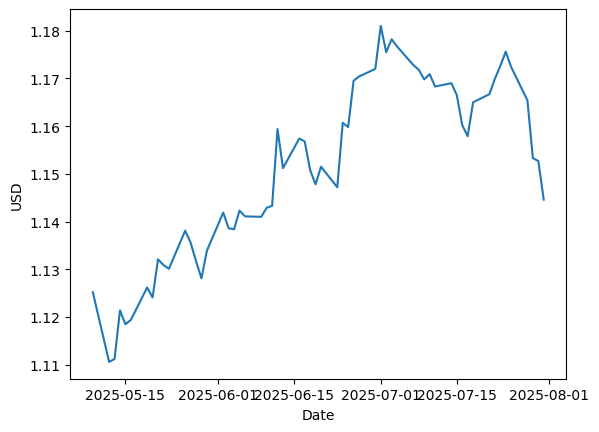

In [95]:
# plot the latest 60 days of data
sns.lineplot(usd.iloc[-60:])